In [1]:
import pandas as pd
import seaborn as sn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,MinMaxScaler
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import LSTM,Activation,Dropout
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import numpy as np

In [2]:
df=pd.read_csv("C:\\AI4H\\TEAM_SEAN\\Dataset\\rayongDairy.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              3654 non-null   object 
 1   maxTemp           3654 non-null   float64
 2   minTemp           3654 non-null   float64
 3   WindSpeed         3654 non-null   float64
 4   RelativeHumidity  3654 non-null   float64
 5   Precipitation     3654 non-null   float64
dtypes: float64(5), object(1)
memory usage: 171.4+ KB


In [4]:
df

,date,maxTemp,minTemp,WindSpeed,RelativeHumidity,Precipitation
0,1/1/2012,28.47,24.58,3.40,77.44,0.17
1,2/1/2012,28.59,25.25,2.73,77.00,1.83
2,3/1/2012,26.72,25.98,1.02,82.12,11.77
3,4/1/2012,27.60,25.65,1.81,81.19,8.04
4,5/1/2012,28.13,25.65,2.45,76.38,2.06
...,...,...,...,...,...,...
3649,28/12/2021,28.37,22.98,5.59,76.69,0.03
3650,29/12/2021,29.05,24.23,4.95,79.19,0.61
3651,30/12/2021,28.10,24.74,5.10,80.06,0.31
3652,31/12/2021,28.57,23.87,5.01,77.62,0.00


In [5]:
df['date'][2921]

'31/12/2019'

In [6]:
#Find same day in dataset
for i in range(len(df)-1):
    if df['date'][i] == df['date'][i+1]:
        print(i,df['date'][i])

In [7]:
formular = 'maxTemp ~minTemp+WindSpeed+RelativeHumidity+Precipitation'

In [8]:
target = "maxTemp"

In [9]:
variable = formular.split('~')
print(variable)
variable = variable[1].split('+')
print(variable)

['maxTemp ', 'minTemp+WindSpeed+RelativeHumidity+Precipitation']
['minTemp', 'WindSpeed', 'RelativeHumidity', 'Precipitation']


In [10]:
variable = [ 'date' , target ] + variable

In [11]:
len(variable)

6

In [12]:
nTar = len(variable)-1

In [13]:
df = df[variable]

In [14]:
df.head()

,date,maxTemp,minTemp,WindSpeed,RelativeHumidity,Precipitation
0,1/1/2012,28.47,24.58,3.40,77.44,0.17
1,2/1/2012,28.59,25.25,2.73,77.00,1.83
2,3/1/2012,26.72,25.98,1.02,82.12,11.77
3,4/1/2012,27.60,25.65,1.81,81.19,8.04
4,5/1/2012,28.13,25.65,2.45,76.38,2.06


In [15]:
#หาข้อมูลที่เป็น null
df.isnull().sum()

date                0
maxTemp             0
minTemp             0
WindSpeed           0
RelativeHumidity    0
Precipitation       0
dtype: int64

In [16]:
count = (df['maxTemp'] == 0).sum()
print(count)

0


In [17]:
count = (df['minTemp'] == 0).sum()
print(count)

0


In [18]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              3654 non-null   object 
 1   maxTemp           3654 non-null   float64
 2   minTemp           3654 non-null   float64
 3   WindSpeed         3654 non-null   float64
 4   RelativeHumidity  3654 non-null   float64
 5   Precipitation     3654 non-null   float64
dtypes: float64(5), object(1)
memory usage: 171.4+ KB


In [19]:
df.corr()

,maxTemp,minTemp,WindSpeed,RelativeHumidity,Precipitation
maxTemp,1.000000,0.681976,-0.213231,-0.241672,-0.201044
minTemp,0.681976,1.000000,-0.167818,0.323480,0.145913
WindSpeed,-0.213231,-0.167818,1.000000,0.220884,0.249888
RelativeHumidity,-0.241672,0.323480,0.220884,1.000000,0.462532
Precipitation,-0.201044,0.145913,0.249888,0.462532,1.000000


<AxesSubplot:>

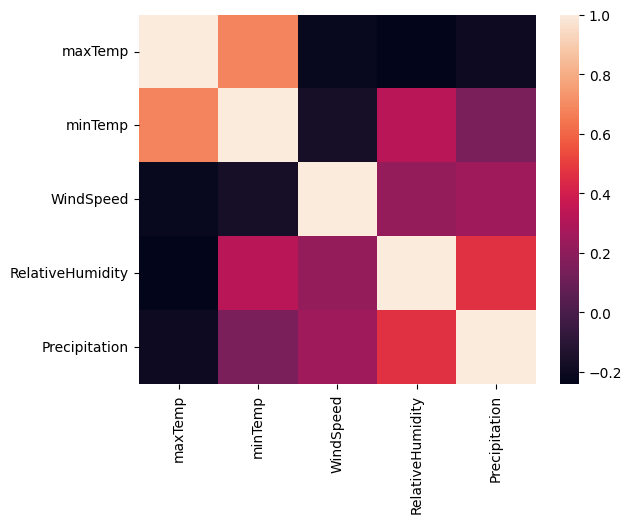

In [20]:
sn.heatmap(df.corr())

In [21]:
tempdf = df
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              3654 non-null   object 
 1   maxTemp           3654 non-null   float64
 2   minTemp           3654 non-null   float64
 3   WindSpeed         3654 non-null   float64
 4   RelativeHumidity  3654 non-null   float64
 5   Precipitation     3654 non-null   float64
dtypes: float64(5), object(1)
memory usage: 171.4+ KB


In [22]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, sampling=1, dropnan=True): 
    n_vars = 1 if type(data) is list else data.shape[1] 
    df = pd.DataFrame(data) 
    cols, names = list(), list() 
    # input sequence (t-n, ... t-1) 
    sampling*=-1
    for i in range(n_in, 0, sampling):  
        cols.append(df.shift(i))  
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)] 
    # forecast sequence (t, t+1, ... t+n) 
    for i in range(0, n_out):  
        cols.append(df.shift(-i))  
        if i == 0:   
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]  
        else:   
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)] 
    # put it all together 
    agg = pd.concat(cols, axis=1) 
    agg.columns = names 
    # drop rows with NaN values 
    if dropnan:  
        agg.dropna(inplace=True) 
    return agg 

In [23]:
df=df.drop('date',axis=1)

In [24]:
df.index.name='date'

In [25]:
data=df.values
print(df.maxTemp.min())
df.maxTemp.max()

24.04


33.09

In [26]:
# ensure all data is float
data=data.astype('float32')

In [27]:
# normalize features
scaler=MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(data)

ปรับ node และ dense node เป็น 32 64 128 256 (4^2=16 การทดลอง)

In [28]:
# specify no. of lag hours
L1 = 200
dense_node = 50
n_day = 45
n_features = nTar

In [29]:
# frame as supervised learning
reframed = series_to_supervised(scaled,n_day,1)
print(reframed.shape)

(3609, 230)


In [30]:
print(reframed)

      var1(t-45)  var2(t-45)  var3(t-45)  var4(t-45)  var5(t-45)  var1(t-44)  \
45      0.489502    0.518043    0.306286    0.654996    0.001642    0.502762   
46      0.502762    0.571772    0.229714    0.643146    0.017679    0.296132   
47      0.296132    0.630313    0.034286    0.781040    0.113709    0.393370   
48      0.393370    0.603849    0.124571    0.755993    0.077674    0.451933   
49      0.451933    0.603849    0.197714    0.626448    0.019901    0.548066   
...          ...         ...         ...         ...         ...         ...   
3649    0.508287    0.630313    0.593143    0.809857    0.026761    0.483978   
3650    0.483978    0.620690    0.572571    0.807972    0.182205    0.585635   
3651    0.585635    0.647153    0.340571    0.762726    0.044633    0.606630   
3652    0.606630    0.720930    0.414857    0.843523    0.041832    0.671823   
3653    0.671823    0.715317    0.393143    0.794506    0.018162    0.586740   

      var2(t-44)  var3(t-44)  var4(t-44

In [31]:
values = reframed.values

In [32]:
n_train_hours=(365*8)

In [33]:
#[row,col]
train = values[:n_train_hours,:]
test = values[n_train_hours:, : ]

In [34]:
# split into input and outputs
n_obs = n_day * n_features
train_X,train_Y = train[:,:n_obs],train[:,-nTar]   # as at 6th no. from last is temp. our o/p var
print(train_X.shape)
print(train_Y.shape)
test_X,test_Y = test[:,:n_obs],test[:,-nTar]

(2920, 225)
(2920,)


In [35]:
print(train_X.shape,len(train_X),train_Y.shape)

(2920, 225) 2920 (2920,)


In [36]:
# reshape input to be 3D [samples, timesteps, fetures]
train_X = train_X.reshape((train_X.shape[0],n_day,n_features))
test_X = test_X.reshape((test_X.shape[0],n_day,n_features))  # 24 = 3 * 8
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(2920, 45, 5) (2920,) (689, 45, 5) (689,)


In [37]:
print(train_X.shape[1])
print(train_X.shape[2])

45
5


In [38]:
hidden_nodes = int(2/3 * (train_X.shape[1] * train_X.shape[2]))
print(hidden_nodes)

150


In [39]:
model = Sequential()
model.add(LSTM(L1, input_shape=(train_X.shape[1], train_X.shape[2])))    
# test
model.add(Dense(dense_node,name='FC1'))  
model.add(Activation('relu'))
model.add(Dropout(0.2))
# end
model.add(Dense(1,name='out_layer'))
model.compile(loss='mean_squared_error',optimizer='adam', metrics=['mean_squared_error'])

In [40]:
# fit network
history = model.fit(train_X, train_Y, epochs=100, batch_size=32, validation_data=(test_X, test_Y), verbose=2, shuffle=False)

Epoch 1/100
92/92 - 23s - loss: 0.0249 - mean_squared_error: 0.0249 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - 23s/epoch - 250ms/step
Epoch 2/100
92/92 - 2s - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - 2s/epoch - 25ms/step
Epoch 3/100
92/92 - 2s - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - 2s/epoch - 25ms/step
Epoch 4/100
92/92 - 3s - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - 3s/epoch - 30ms/step
Epoch 5/100
92/92 - 3s - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - 3s/epoch - 33ms/step
Epoch 6/100
92/92 - 4s - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - 4s/epoch - 40ms/step
Epoch 7/100
92/92 - 3s - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - 3s/epoch - 37ms/step
Epo

Epoch 59/100
92/92 - 5s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - 5s/epoch - 51ms/step
Epoch 60/100
92/92 - 5s - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - 5s/epoch - 59ms/step
Epoch 61/100
92/92 - 4s - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - 4s/epoch - 48ms/step
Epoch 62/100
92/92 - 6s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - 6s/epoch - 65ms/step
Epoch 63/100
92/92 - 6s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - 6s/epoch - 71ms/step
Epoch 64/100
92/92 - 4s - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - 4s/epoch - 42ms/step
Epoch 65/100
92/92 - 5s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - 5s/epoch - 50ms/step

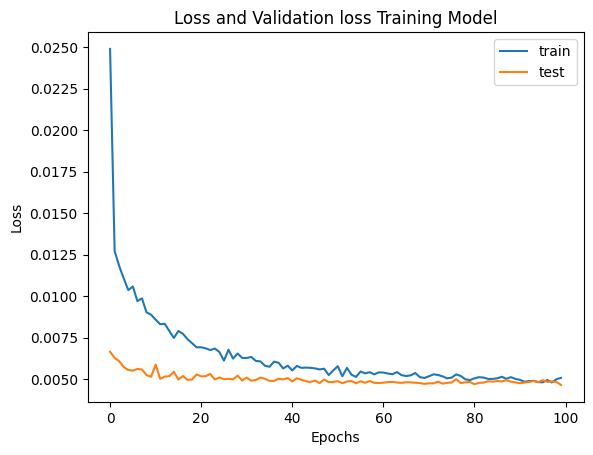

In [41]:
# plot history
pyplot.title('Loss and Validation loss Training Model')
pyplot.plot(history.history['loss'], label='train')
pyplot.xlabel('Epochs')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.ylabel('Loss')
pyplot.legend()
pyplot.show()

In [42]:
# make a prediction
test_Y_predicted = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_day*n_features))

22/22 [==============================] - 7s 21ms/step


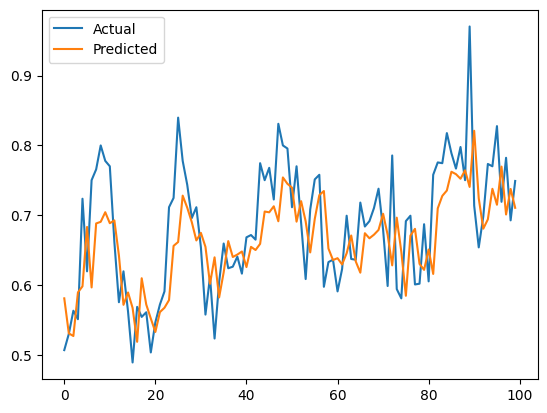

In [43]:
pyplot.plot(test_Y[:100],label="Actual")
pyplot.plot(test_Y_predicted[:100],label="Predicted")
pyplot.legend()

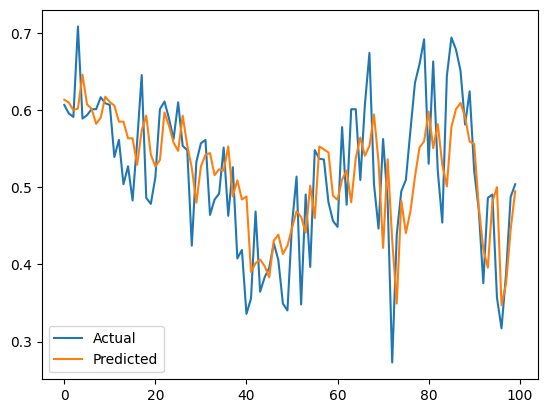

In [44]:
pyplot.plot(test_Y[200:300],label="Actual")
pyplot.plot(test_Y_predicted[200:300],label="Predicted")
pyplot.legend()

In [45]:
# invert scaling for forecast

inv_test_Y_predicted = np.concatenate((test_Y_predicted,test_X[:,-(nTar-1):]),axis=1)
inv_test_Y_predicted = scaler.inverse_transform(inv_test_Y_predicted)
inv_test_Y_predicted = inv_test_Y_predicted[:,0]
#print(inv_test_Y_predicted)

In [46]:
# invert scaling for actual
test_Y = test_Y.reshape((len(test_Y), 1))
inv_test_Y = np.concatenate((test_Y,test_X[:,-(nTar-1):]),axis=1)
inv_test_Y = scaler.inverse_transform(inv_test_Y)
inv_test_Y = inv_test_Y[:,0]
#print(inv_test_Y)
#print(len(inv_test_Y))

In [47]:
ldate=tempdf['date'].values
ldate=ldate[-len(test_Y):]

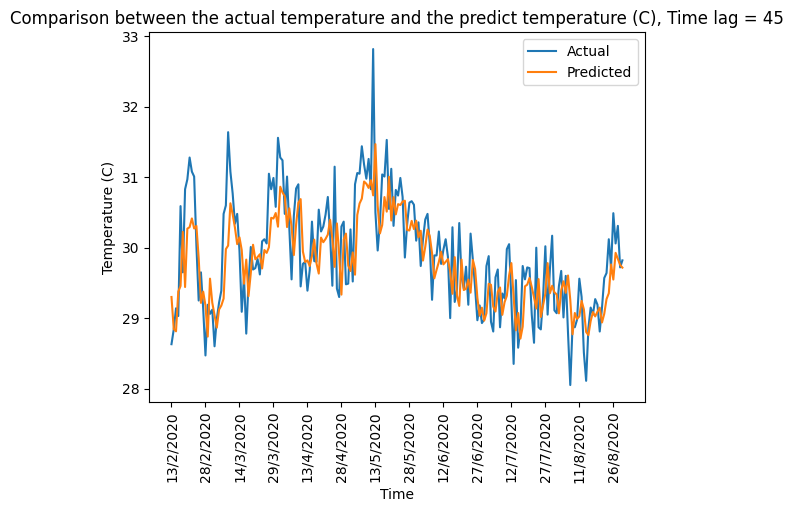

In [48]:
pyplot.title('Comparison between the actual temperature and the predict temperature (C), Time lag = {lag}'.format(lag=n_day))
pyplot.xlabel('Time')
pyplot.xticks(range(0, 200,15),rotation = 90)
pyplot.ylabel('Temperature (C)')
pyplot.plot(ldate[:200],inv_test_Y[:200],label="Actual")
pyplot.plot(ldate[:200],inv_test_Y_predicted[:200],label="Predicted")
pyplot.legend()

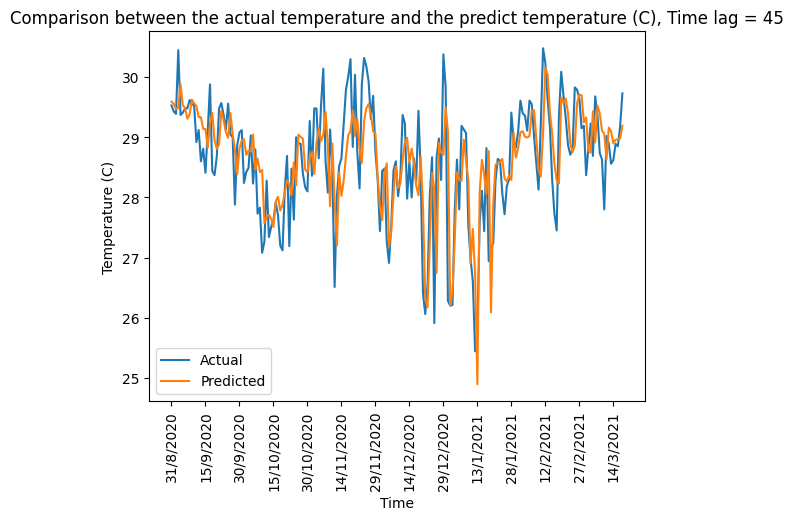

In [49]:
pyplot.title('Comparison between the actual temperature and the predict temperature (C), Time lag = {lag}'.format(lag=n_day))
pyplot.xlabel('Time')
pyplot.xticks(range(0, 200,15),rotation = 90)
pyplot.ylabel('Temperature (C)')
pyplot.plot(ldate[200:400],inv_test_Y[200:400],label="Actual")
pyplot.plot(ldate[200:400],inv_test_Y_predicted[200:400],label="Predicted")
pyplot.legend()

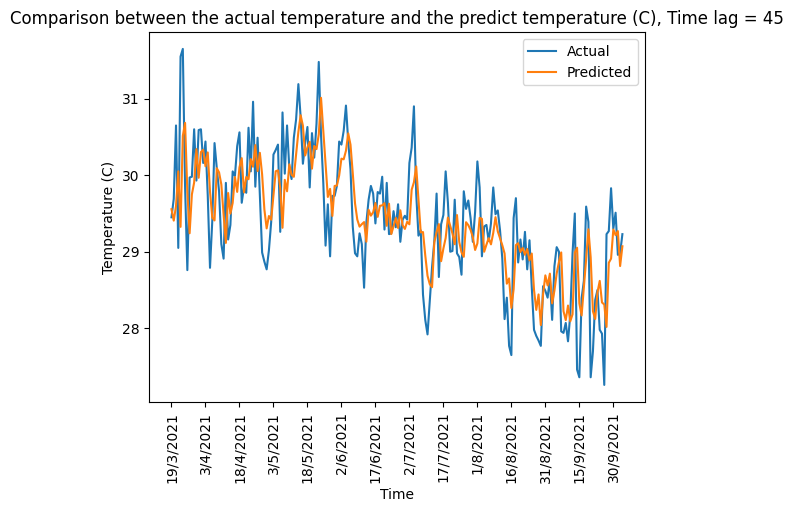

In [50]:
pyplot.title('Comparison between the actual temperature and the predict temperature (C), Time lag = {lag}'.format(lag=n_day))
pyplot.xlabel('Time')
pyplot.xticks(range(0, 200,15),rotation = 90)
pyplot.ylabel('Temperature (C)')
pyplot.plot(ldate[400:600],inv_test_Y[400:600],label="Actual")
pyplot.plot(ldate[400:600],inv_test_Y_predicted[400:600],label="Predicted")
pyplot.legend()

#RMSE รวมบันทึกผล

In [51]:
# calculate RMSE
from math import sqrt
rmse_total = sqrt(mean_squared_error(inv_test_Y, inv_test_Y_predicted))
print('Test RMSE: %.3f' % rmse_total) 

Test RMSE: 0.618


2 2020
Test RMSE: 0.701
3 2020
Test RMSE: 0.564
4 2020
Test RMSE: 0.597
5 2020
Test RMSE: 0.661
6 2020
Test RMSE: 0.451
7 2020
Test RMSE: 0.536
8 2020
Test RMSE: 0.460
9 2020
Test RMSE: 0.476
10 2020
Test RMSE: 0.572
11 2020
Test RMSE: 0.836
12 2020
Test RMSE: 0.856
1 2021
Test RMSE: 0.695
2 2021
Test RMSE: 0.583
3 2021
Test RMSE: 0.751
4 2021
Test RMSE: 0.562
5 2021
Test RMSE: 0.564
6 2021
Test RMSE: 0.387
7 2021
Test RMSE: 0.519
8 2021
Test RMSE: 0.476
9 2021
Test RMSE: 0.683
10 2021
Test RMSE: 0.608


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAX RMSE: 0.856
MIN RMSE: 0.387


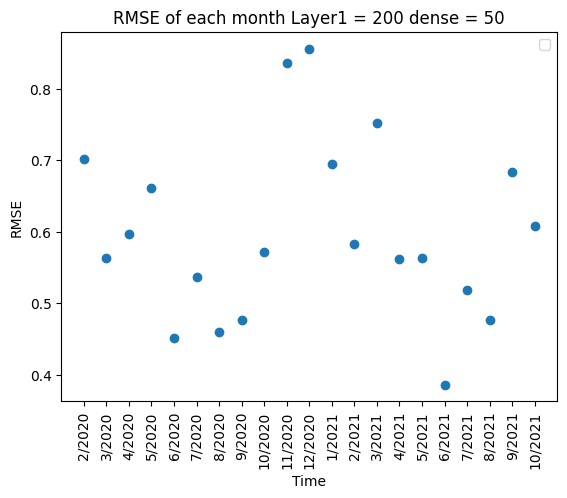

In [52]:
date=pd.DataFrame(tempdf['date'], columns=['date'])
date=date[-len(test_Y):]
date['Actual'] = inv_test_Y
date['Predicted'] = inv_test_Y_predicted

result = []
Actual = []
month = []
Predicted = []
for i  in date.index :
    
    timeX=date.loc[i,'date']
    timeX = timeX.split('/')
    if(i+1<=len(train_Y)+len(test_Y)) :
        timeY=date.loc[i+1,'date']
        timeY = timeY.split('/')
    else :
        timeY=date.loc[i,'date']
        timeY = timeY.split('/')
    
    if(timeX[1]==timeY[1] and timeX[2]==timeY[2]) :
        Actual.append(date.loc[i,'Actual'])
        Predicted.append(date.loc[i,'Predicted'])
    else :
        print(timeX[1],timeX[2])
        rmse = sqrt(mean_squared_error(Actual,Predicted))
        print('Test RMSE: %.3f' % rmse)
        month.append(timeX[1]+'/'+timeX[2])
        result.append(rmse) 
        Actual.clear()
        Predicted.clear()

pyplot.title('RMSE of each month Layer1 = {L1} dense = {dense}'.format(L1=L1,dense=dense_node,r=rmse_total))
pyplot.xlabel('Time')
pyplot.xticks(rotation = 90)
pyplot.ylabel('RMSE')
pyplot.scatter(month,result)
pyplot.legend()
max_value = np.max(result)
min_value = np.min(result)
print('MAX RMSE: %.3f\nMIN RMSE: %.3f' % (max_value,min_value))

Dataset เชียงราย (index)
2 2018 = 0 : 13
3 2018 = 14 : 45
4 2018 = 46 : 76
5 2018 = 77 : 108
6 2018 = 108 : 138
7 2018 = 138 : 169
8 2018 = 169 : 200
9 2018 = 200 : 230
10 2018 = 230 : 261
11 2018 = 261 : 291
12 2018 = 291 : 322
1 2019 = 322 : 353
2 2019 = 353 : 381
3 2019 = 381 : 412
4 2019 = 412 : 442
5 2019 = 442 : 473
6 2019 = 473 : 503
7 2019 = 503 : 534
8 2019 = 534 : 564
9 2019 = 564 : 594

Dataset ระยอง (index)
2 2020 = :17
3 2020 = 17:48
4 2020 = 48:78
5 2020 = 78:109
6 2020 = 109:139
7 2020 = 139:170
8 2020 = 170:201
9 2020 = 201:231
10 2020 = 231:262
11 2020 = 262:292
12 2020 = 292:323
1 2021 = 323:354
2 2021 = 355:383
3 2021 = 383:414
4 2021 = 414:444
5 2021 = 444:475
6 2021 = 474:504
7 2021 = 504:535
8 2021 = 535:566
9 2021 = 566:596
10 2021 = 596:627

##BEST RMSE บันทึกผล

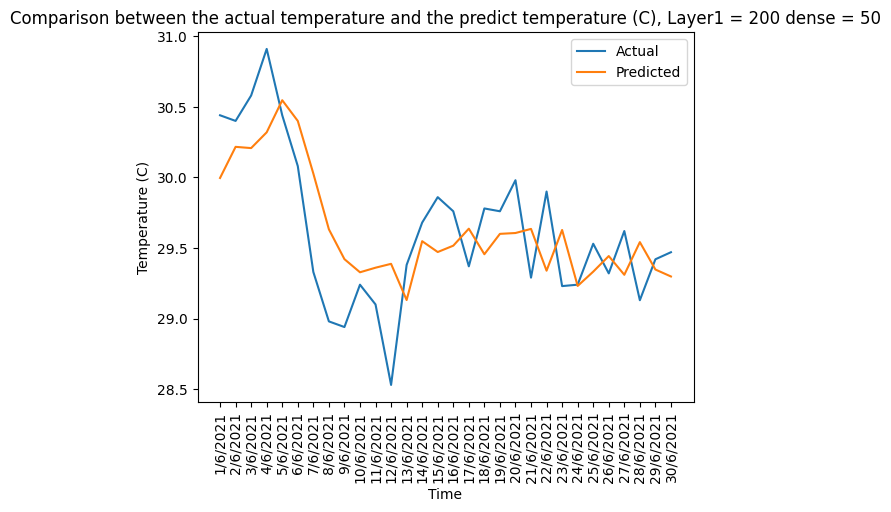

In [53]:
pyplot.title('Comparison between the actual temperature and the predict temperature (C), Layer1 = {L1} dense = {dense}'.format(L1=L1,dense=dense_node))
pyplot.xlabel('Time')
pyplot.xticks(range(0, 30,1),rotation = 90)
pyplot.ylabel('Temperature (C)')
pyplot.plot(ldate[474:504],inv_test_Y[474:504],label="Actual")
pyplot.plot(ldate[474:504],inv_test_Y_predicted[474:504],label="Predicted")
pyplot.legend()

In [54]:
inv_test_Y[474:504]

array([30.44    , 30.4     , 30.58    , 30.91    , 30.44    , 30.08    ,
       29.33    , 28.980001, 28.94    , 29.24    , 29.1     , 28.529999,
       29.38    , 29.68    , 29.86    , 29.76    , 29.37    , 29.78    ,
       29.76    , 29.980001, 29.289999, 29.9     , 29.23    , 29.24    ,
       29.530003, 29.32    , 29.62    , 29.13    , 29.42    , 29.47    ],
      dtype=float32)

In [55]:
inv_test_Y_predicted[474:504]

array([29.995886, 30.216345, 30.207554, 30.319288, 30.546604, 30.399832,
       30.027233, 29.63233 , 29.420897, 29.327904, 29.360313, 29.387728,
       29.131298, 29.548061, 29.47136 , 29.516296, 29.636839, 29.45573 ,
       29.600012, 29.605999, 29.635193, 29.339191, 29.627567, 29.231129,
       29.33224 , 29.44287 , 29.310043, 29.541506, 29.347322, 29.298101],
      dtype=float32)

##WORST RMSE บันทึกผล

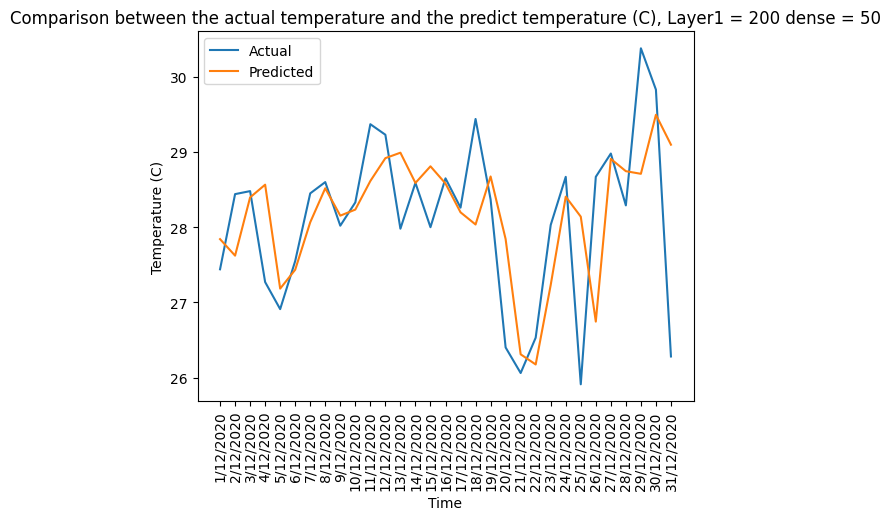

In [56]:
pyplot.title('Comparison between the actual temperature and the predict temperature (C), Layer1 = {L1} dense = {dense}'.format(L1=L1,dense=dense_node))
pyplot.xlabel('Time')
pyplot.xticks(range(0, 31,1),rotation = 90)
pyplot.ylabel('Temperature (C)')
pyplot.plot(ldate[292:323],inv_test_Y[292:323],label="Actual")
pyplot.plot(ldate[292:323],inv_test_Y_predicted[292:323],label="Predicted")
pyplot.legend()

In [57]:
inv_test_Y[292:323]

array([27.44    , 28.44    , 28.48    , 27.27    , 26.909998, 27.55    ,
       28.45    , 28.599998, 28.02    , 28.33    , 29.37    , 29.23    ,
       27.979998, 28.59    , 28.      , 28.65    , 28.26    , 29.44    ,
       28.37    , 26.4     , 26.06    , 26.53    , 28.03    , 28.669998,
       25.91    , 28.669998, 28.980001, 28.29    , 30.38    , 29.83    ,
       26.28    ], dtype=float32)

In [58]:
inv_test_Y_predicted[292:323]

array([27.841278, 27.621515, 28.396717, 28.565533, 27.182886, 27.434126,
       28.06521 , 28.517992, 28.153746, 28.234173, 28.614439, 28.918583,
       28.99115 , 28.588911, 28.810041, 28.581146, 28.197828, 28.035858,
       28.674871, 27.842155, 26.308884, 26.173866, 27.23169 , 28.406275,
       28.140114, 26.743996, 28.908295, 28.7451  , 28.710287, 29.495432,
       29.097635], dtype=float32)

In [59]:
# comparing actual temperature and predicted temperature predicted using data of 3 previous hours
df_result=pd.DataFrame({'date':ldate,'Actual_Temperature':inv_test_Y,'Predicted_Temperature':inv_test_Y_predicted})

In [60]:
pd.set_option('display.precision',2)
df_result.head()

,date,Actual_Temperature,Predicted_Temperature
0,13/2/2020,28.63,29.30
1,14/2/2020,28.84,28.85
2,15/2/2020,29.14,28.81
3,16/2/2020,29.03,29.38
4,17/2/2020,30.59,29.46


In [61]:
df_result.to_csv("weather_result.csv")